In [25]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import time

In [26]:
mean1 = [0.0, 0.0]
mean2 = [2.0, 1.0]
cov1 = [[.7, .5], [.5, .7]]
cov2 = [[.1, -.05], [-.05, .1]]

data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=500)

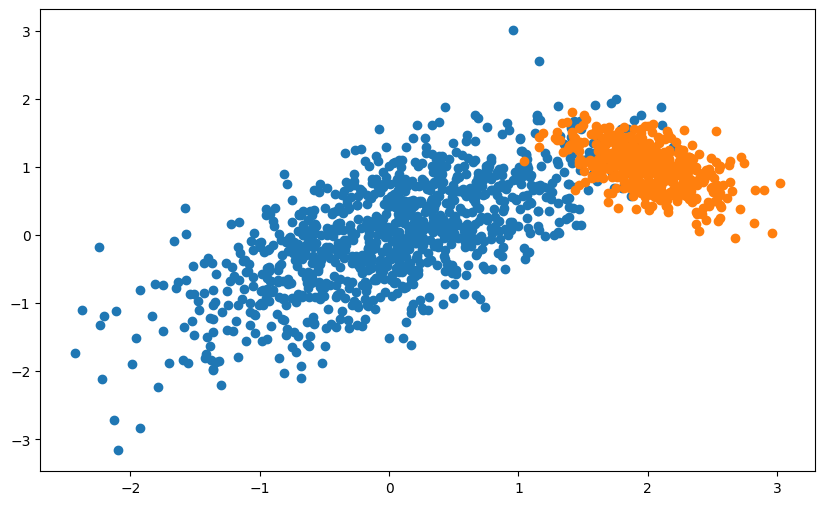

In [27]:
def plot_scatter(data_list):
    plt.figure(figsize=(10, 6))
    for data in data_list:
        plt.scatter(data[:,0], data[:,1])
    plt.show()

plot_scatter([data1, data2])

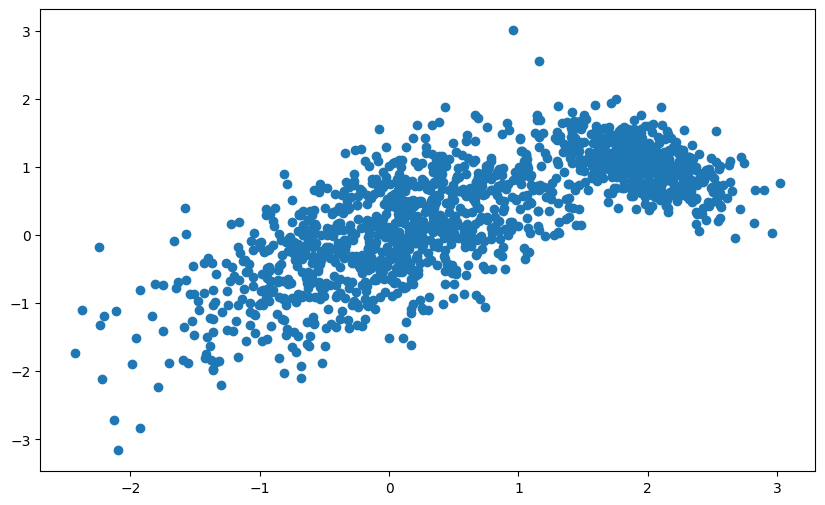

In [28]:
X = np.vstack((data1, data2))
plot_scatter([X])

In [29]:
@numba.jit(parallel=True)
def compute_component_pdf(x, mus, sigmas):
    """
    mus: K x d array
    sigmas: K x d x d array
    """
    def compute_gaussian_pdf(x, mu, sigma):
        """
        x: d array
        mu: d array
        sigma: d x d array
        """
        d = len(x)
        pdf = (((np.pi)**d) * np.linalg.det(sigma))**(-0.5) * np.exp(-0.5 * (x - mu) @ np.linalg.solve(sigma, (x - mu).T))
        return pdf

    num_component = len(mus)
    return np.array([compute_gaussian_pdf(x, mus[k, :], sigmas[k, :, :]) for k in range(num_component)])

Computing the likelihood function of Mixture of Gaussians for parameter $\theta_{k} = (\pi_{k},\mu_{k},\Sigma_{k})$

$$
L(\mathcal{D}_{\textsf{data}}|\theta_{1},\ldots,\theta_{K})=\prod_{n=1}^{N}\left(\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{n}|\mu_{k},\Sigma_{k})\right)
$$

By applying the $\log$ transform,

$$
\log L(\mathcal{D}_{\textsf{data}}|\theta_{1},\ldots,\theta_{K})=\sum_{n=1}^{N}\log P(x_{n}|\theta_{1},\ldots,\theta_{K})
$$
where $P(x|\theta_{1},\ldots,\theta_{K})=\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x|\mu_{k},\Sigma_{k})$.

In [30]:
def compute_log_likelihood_function(X, weights, mus, sigmas):
    """
    X: N x d array
    weights: K-dim vector (K, ) array
    mus: K x d array
    sigmas: K x d x d array
    """
    weights = weights.reshape(-1, 1) # (K, 1)
    # def compute_component_prob(x):
    #     return compute_component_pdf(x, mus, sigmas)
    compute_component_prob = lambda x: compute_component_pdf(x, mus, sigmas)
    # prob_nk = np.array([compute_component_pdf(x, mus, sigmas) for x in X])
    prob_nk = np.apply_along_axis(arr=X, func1d=compute_component_prob, axis=1) # (N, K)
    prob_component = prob_nk * weights.T # (N, K)
    likelihood = np.sum(prob_component, axis=1) # (N, 1)
    return likelihood, prob_component, np.sum(np.log(likelihood))

E-step: compute the responsibilities for given $\theta_{1},\ldots,\theta_{K}$

$$
\gamma_{nk} = \frac{\pi_{k}\mathcal{N}(x_{n}|\mu_{k},\Sigma_{k})}{P(x_{n}|\theta_{1},\ldots,\theta_{K})}
$$

In [31]:
def compute_responsibility(likelihood, prob_component):
    return prob_component / likelihood # (N, K)

M-step: compute the parameters $\theta_{1},\ldots,\theta_{K}$: set $N_{k} = \sum_{n=1}^{N}\gamma_{nk}$, and

$$
\pi_{k} = \frac{N_{k}}{N}, \quad \mu_{k} = \frac{1}{N_{k}}\sum_{n=1}^{N}\gamma_{nk}\mathbf{x}_{n}
$$
$$
\Sigma_{k} = \frac{1}{N_{k}}\sum_{n=1}^{N}\gamma_{nk}(\mathbf{x}_{n}-\mu_{k})(\mathbf{x}_{n}-\mu_{k})^{\top}
$$

In [32]:
def compute_weights(N, N_k):
    """compute (pi_1,...,pi_K): K-dim vector"""
    return N_k / N # (1, K)

def compute_mus(X, gamma, N_k):
    """compute (mu_1,...,mu_K): (K, d) matrix"""
    return (gamma.T @ X) / N_k[:, np.newaxis] # (K, N) x (N, d) = (K, d)

def compute_covariance(X, gamma, mus, N_k):
    """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
    centered_X = (X[np.newaxis, :, :] - mus[:, np.newaxis, :])[:, :, :, np.newaxis] # (K, N, d, 1)
    cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2) # (K, N, d, d)
    cov_matrix = (gamma.T)[:, :, np.newaxis, np.newaxis] * cov_matrix # (K, N, d, d)
    return np.sum(cov_matrix, axis=1) / N_k[:, np.newaxis, np.newaxis] # (K, d, d)

In [33]:
class GaussianMixture():
    def __init__(self, num_components=2):
        self.num_components = num_components
        self.weights = None
        self.mus = None
        self.sigmas = None
        self.log_likelihood = None
        self.gamma = None
        self.X = None
        self.N = None

    def init_parameters(self):
        self.weights = np.ones(self.num_components) / self.num_components
        self.mus = self.X[np.random.choice(np.arange(self.N), self.num_components, replace=False)]
        self.sigmas = np.array([np.cov(self.X.T) for _ in range(self.num_components)])

    def compute_log_likelihood_function(self):
        likelihood, prob_component, log_likelihood = compute_log_likelihood_function(self.X, self.weights, self.mus, self.sigmas)
        return likelihood, prob_component, log_likelihood

    def compute_responsibility(self, likelihood, prob_component):
        return prob_component / likelihood[:, np.newaxis] # (N, K)

    def compute_weights(self, N_k):
        """compute (pi_1,...,pi_K): K-dim vector"""
        new_weights = compute_weights(self.N, N_k)
        return new_weights

    def compute_mus(self, N_k):
        """compute (mu_1,...,mu_K): (K, d) matrix"""
        new_mus = compute_mus(self.X, self.gamma, N_k)
        return new_mus

    def compute_covariance(self, N_k):
        """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
        new_sigmas = compute_covariance(self.X, self.gamma, self.mus, N_k)
        return new_sigmas

    def E_step(self):
        # parameter initialization
        if self.weights is None:
            self.init_parameters()
        likelihood, prob_component, self.log_likelihood = self.compute_log_likelihood_function()
        self.gamma = self.compute_responsibility(likelihood, prob_component)

    def M_step(self):
        if self.weights is None:
            self.E_step()
        N_k = np.sum(self.gamma, axis=0) # (K, )
        self.weights = self.compute_weights(N_k)
        self.mus = self.compute_mus(N_k)
        self.sigmas = self.compute_covariance(N_k)

    def fit(self, X, max_iter=100, tol=1e-4):
        self.X = X
        self.N = len(self.X)
        self.init_parameters()
        prev_log_likelihood = -np.inf

        start_time = time.time()
        # iterative update
        for iter in range(max_iter):
            self.E_step()

            if self.log_likelihood - prev_log_likelihood < tol:
                break
            else:
                prev_log_likelihood = self.log_likelihood
                self.M_step()

        end_time = time.time()
        wall_clock_time = end_time - start_time
        print(f"EM algorithm is done at {iter}-th step. (wall-clock time: {wall_clock_time} secs)\nLog-likelihood: {self.log_likelihood}")
        print("="*30)
        print(f"- Estimated mixture weights:\n{self.weights}")
        print("-"*20)
        print(f"- Estimated mus:\n{self.mus}")
        print("-"*20)
        print(f"- Estimated sigmas:\n{self.sigmas}")
        print("="*30)

    def sampling(self, sample_size=1000):
        index_set = [num for num in np.arange(self.num_components)]
        index = np.random.choice(index_set, p=self.weights, size=sample_size)
        sampled_data = [np.random.multivariate_normal(self.mus[k, :], self.sigmas[k, :, :], size=sample_size)[index==k] for k in index_set]
        return sampled_data

In [34]:
gmm = GaussianMixture(num_components=2)

In [35]:
gmm.fit(X, max_iter=100)
data = gmm.sampling()

EM algorithm is done at 26-th step. (wall-clock time: 4.9788548946380615 secs)
Log-likelihood: -2071.0105350469357
- Estimated mixture weights:
[0.34232831 0.65767169]
--------------------
- Estimated mus:
[[1.98783319 1.01558381]
 [0.02950569 0.01258335]]
--------------------
- Estimated sigmas:
[[[ 0.10094672 -0.05186274]
  [-0.05186274  0.09732256]]

 [[ 0.63103886  0.42787407]
  [ 0.42787407  0.65344727]]]


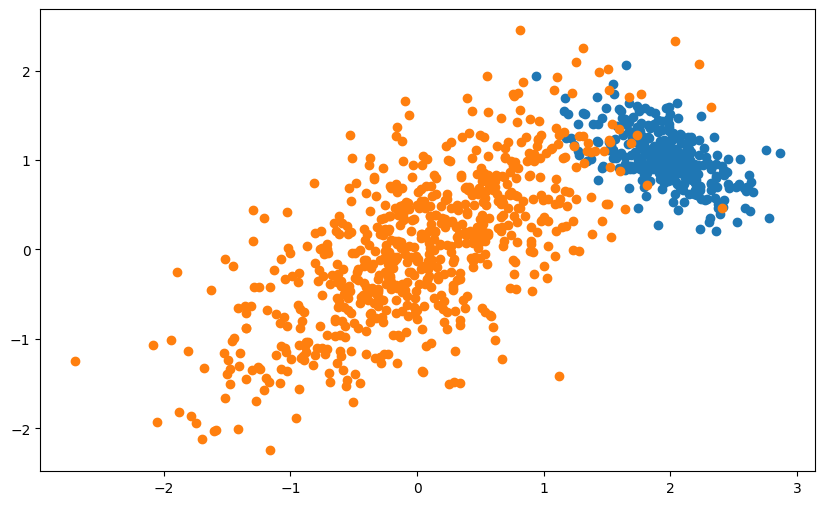

In [36]:
plot_scatter(data)

## Example: 2D clustering with 2 components

In [37]:
mean1 = [0.0, 0.0]
mean2 = [2.0, 1.0]
mean3 = [3.0, 0.5]
cov1 = [[.7, .5], [.5, .7]]
cov2 = [[.1, -.05], [-.05, .1]]
cov3 = [[.3, .2], [.2, .3]]

data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=500)
data3 = np.random.multivariate_normal(mean3, cov3, size=500)

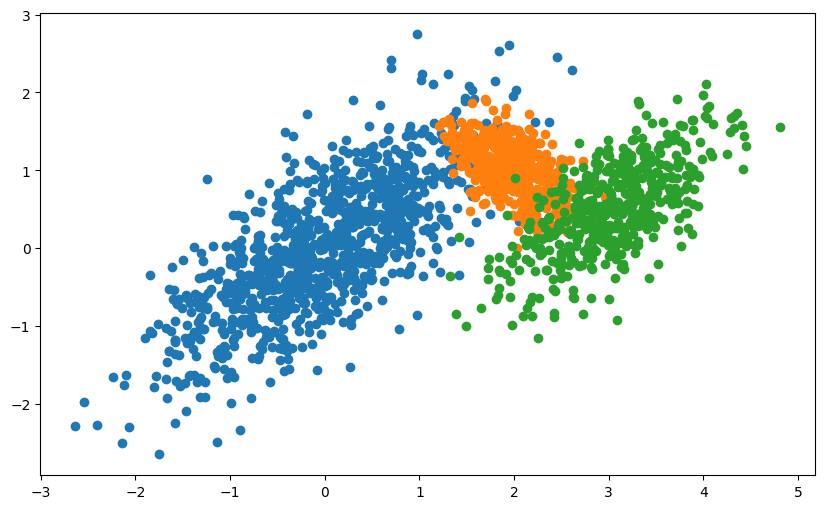

In [38]:
plot_scatter([data1, data2, data3])

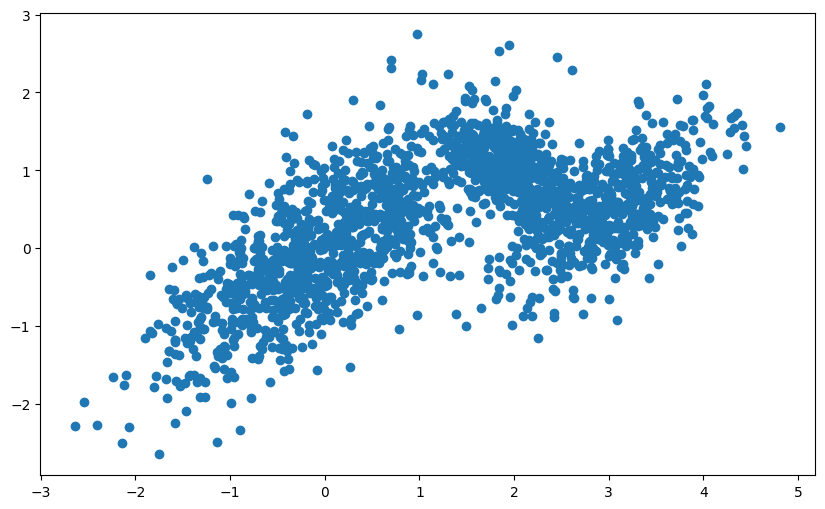

In [39]:
X = np.vstack((data1, data2, data3))
plot_scatter([X])

In [49]:
gmm = GaussianMixture(num_components=3)

In [50]:
gmm.fit(X, max_iter=200)
sampled_data = gmm.sampling(sample_size=2000)

EM algorithm is done at 38-th step. (wall-clock time: 1.4918880462646484 secs)
Log-likelihood: -3506.3754200693324
- Estimated mixture weights:
[0.25772422 0.49960599 0.24266979]
--------------------
- Estimated mus:
[[ 3.00109909  0.51423831]
 [-0.0067771   0.01708587]
 [ 1.97453413  1.00761001]]
--------------------
- Estimated sigmas:
[[[ 0.32241412  0.21332734]
  [ 0.21332734  0.33259527]]

 [[ 0.74317335  0.54912354]
  [ 0.54912354  0.74407978]]

 [[ 0.10206238 -0.05485215]
  [-0.05485215  0.10068293]]]


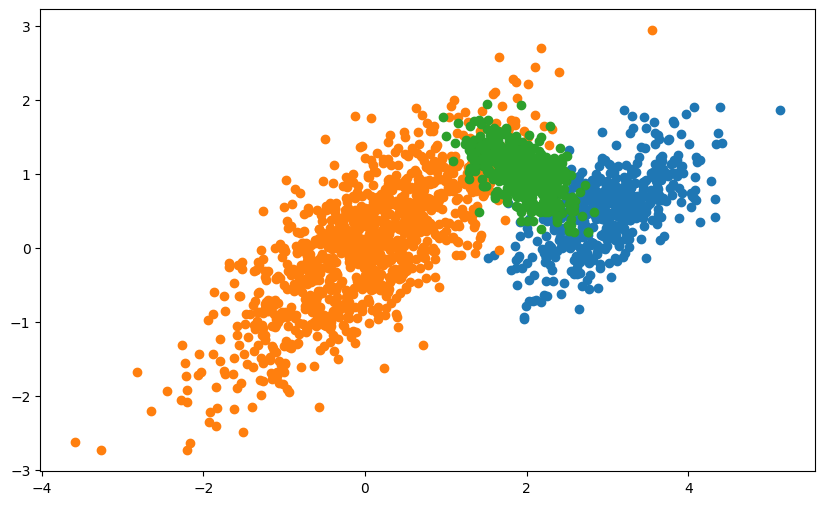

In [51]:
plot_scatter(sampled_data)

## Example: 3D clustering with 3 components

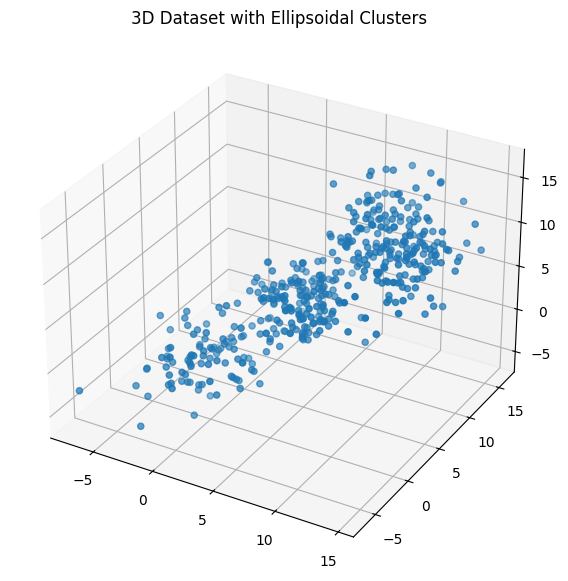

In [43]:
means = np.array([[0, 0, 0], [5, 5, 5], [10, 10, 10]])
covs = [np.eye(3), np.eye(3) * 2, np.eye(3) / 2]  # Different covariances for variety
sizes = [100, 150, 200]  # Different sizes for the clusters
covs_very_spreaded = [
    np.array([[5, 2, 1], [2, 5, 2], [1, 2, 5]]),
    np.array([[5, -2, 1], [-2, 5, -1], [1, -1, 5]]),
    np.array([[5, 0, -2], [0, 5, 2], [-2, 2, 5]])
]

real_data = np.vstack([np.random.multivariate_normal(mean, cov, size) for mean, cov, size in zip(means, covs_very_spreaded, sizes)])

# Plotting the generated very spreaded ellipsoidal clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_data[:, 0], real_data[:, 1], real_data[:, 2])
ax.set_title('3D Dataset with Ellipsoidal Clusters')
plt.show()

In [44]:
gmm_3d = GaussianMixture(num_components=3)
gmm_3d.fit(real_data, max_iter=200)
sampled_data_3d = gmm_3d.sampling(sample_size=2000)

EM algorithm is done at 199-th step. (wall-clock time: 1.7752821445465088 secs)
Log-likelihood: -2920.6283357882985
- Estimated mixture weights:
[0.40688995 0.21376045 0.3793496 ]
--------------------
- Estimated mus:
[[ 3.15037887  4.27107128  3.47302958]
 [ 4.48896311  2.44481542  3.801272  ]
 [10.04450642 10.07401411 10.31089153]]
--------------------
- Estimated sigmas:
[[[ 9.91015778  9.61069418  9.2200031 ]
  [ 9.61069418 16.55235611 11.75135771]
  [ 9.2200031  11.75135771 15.12247405]]

 [[19.84193046  9.08891345 11.30849359]
  [ 9.08891345  8.02246007  5.32141661]
  [11.30849359  5.32141661 10.71256863]]

 [[ 4.47906616  0.24196818 -2.32413802]
  [ 0.24196818  4.19458021  1.83728302]
  [-2.32413802  1.83728302  5.48080941]]]


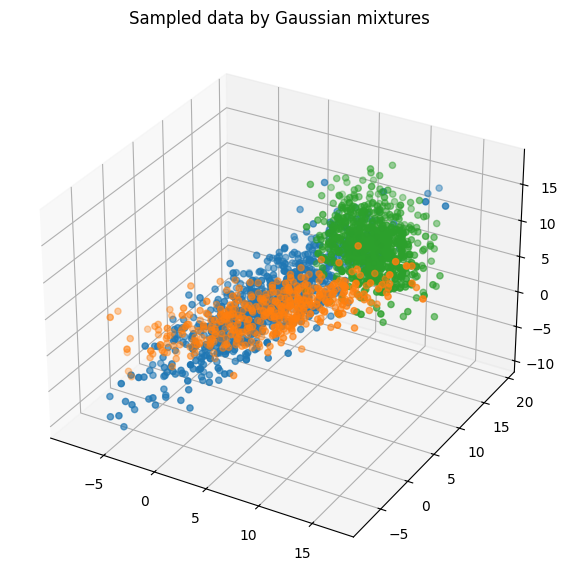

In [45]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(3):
    ax.scatter(sampled_data_3d[i][:, 0], sampled_data_3d[i][:, 1], sampled_data_3d[i][:, 2])
ax.set_title('Sampled data by Gaussian mixtures')
plt.show()

In [46]:
import pandas as pd

# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
!kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data
!unzip palmer-archipelago-antarctica-penguin-data

# load the dataset
df = pd.read_csv('penguins_size.csv')

# remove null values
df = df[~df.isnull().any(axis=1)]
df = df.reset_index(drop=True)
features = ['culmen_length_mm', 'culmen_depth_mm']
data = df[features]
data_ndarray = np.array(data)

Dataset URL: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
License(s): CC0-1.0
palmer-archipelago-antarctica-penguin-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  palmer-archipelago-antarctica-penguin-data.zip
replace penguins_lter.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: penguins_lter.csv       
replace penguins_size.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: penguins_size.csv       


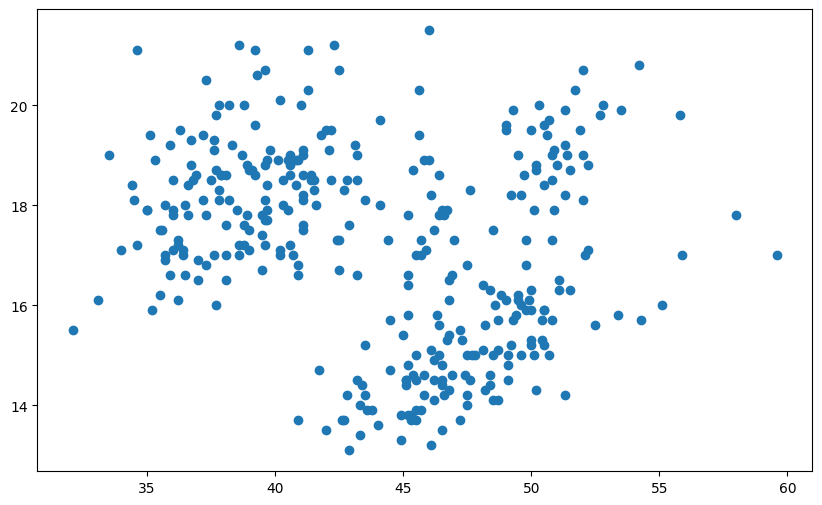

In [47]:
plot_scatter([data_ndarray])

EM algorithm is done at 85-th step. (wall-clock time: 5.280669927597046 secs)
Log-likelihood: -1366.5370378065738
- Estimated mixture weights:
[0.45874963 0.18685226 0.35439811]
--------------------
- Estimated mus:
[[39.04515597 18.3102069 ]
 [49.15426283 18.44672266]
 [47.68020738 14.99406017]]
--------------------
- Estimated sigmas:
[[[ 7.84259228  1.07802054]
  [ 1.07802054  1.47779351]]

 [[ 7.71250345  2.39065603]
  [ 2.39065603  1.38140056]]

 [[10.33500724  2.28378632]
  [ 2.28378632  0.97673819]]]


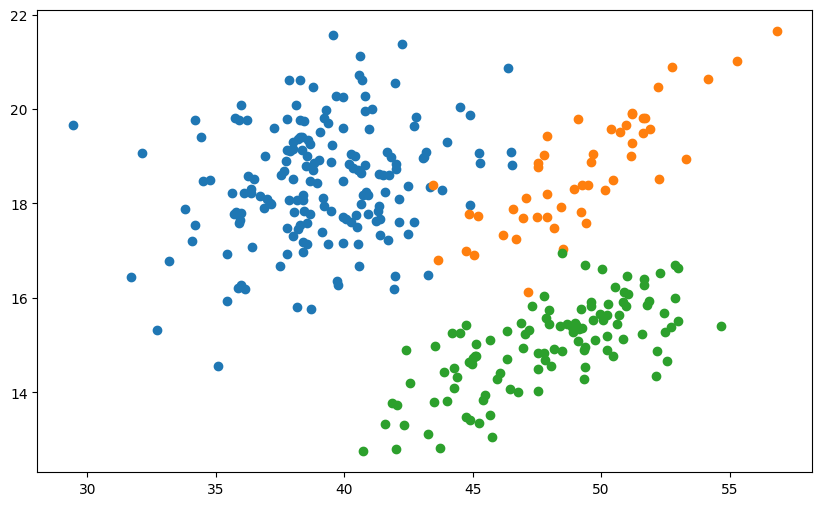

In [48]:
gmm_penguin = GaussianMixture(num_components=3)
gmm_penguin.fit(data_ndarray, max_iter=200)
sampled_data_penguin = gmm_penguin.sampling(sample_size=len(data_ndarray))
plot_scatter(sampled_data_penguin)